# Birmingham Restaurant Industry - Spatial Statistics Analysis

### Table of contents

* [Problem Statement](#Problem-Statement)
* [Importing Libraries](#Importing-Libraries)
* [Loading Data](#Loading-Data)
* [Data Analysis](#Data-Analysis)
    * [Dispersion](#Dispersion)
      * [Distances to own geometric centroids](#Distances-to-own-geometric-centroids)
      * [Standard Deviational Ellipses](#Standard-Deviational-Ellipses)
      * [Kernel Density Estimation](#Kernel-Density-Estimation)
      * [Univariate Local Moran's I](#Univariate-Local-Moran's-I)
    * [Co-location](#Co-location)
      * [Bivariate Ripley K Function](#Bivariate-Ripley-K-Function-(R-code))
    * [Demographic effects](#Demographic-effects)
      * [Receiver Operating Curve](#Receiver-Operating-Curve)
* [Summary](#Summary)


## Problem Statement

I have data of all UK restaurants (reviewed on TropAdvisor from January 25 to February 14, 2018), demographics and coordinates of all UK output areas and Birmingham multipolygon. <br>
Select all the data that falls within Birmingham coordinates.<br>
Perform Spatial Analysis to answer these questions:<br>
<pre>        1) How restaurants of different cuisines locate in relation to the city center? <br>
<pre>        2) How restaurants of different cuisines are spread through the city? <br>
<pre>        3) Are there any relationships between neighborhood demographics and restaurants' cuisine choice? <br>


## Importing Libraries

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from pointpats import centrography
from matplotlib.patches import Ellipse
import numpy as np
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from libpysal.weights.contiguity import Queen
from splot import esda as esdaplot

from libpysal.weights import KNN

## Loading Data

### Loading Maps

In [5]:
from shapely.geometry import Polygon

# Put all my data in a list
points = [b1, b2, b3, b4, b5, b6, b7, b8, b9, b10, b11, b12, b13, b14, b15, b16, b17, b18, b19, b20, b21, b22, b23, b24, 
    b25, b26, b28, b29, b30, b31, b32, b33, b34, b35, b36, b37, b38, b39, b40, b41, b42, b43, b44, b45, b46, b47,
    b48, b49, b50, b51, b52, b53, b54, b55, b56, b57, b58, b60, b62, b63, b64, b66, b67, b69, b70, b71, b72, b73,
    b74, b75, b76, b77, b78, b79, b80, b81, b82, b83, b84,b85, b87, b88, b89, b90, b92, b93, b94, b95, b96, b97,
    b98, b99, b100, b101, b102, b103, b104, b105, b106, b107, b108, b109, b110, b111, b112, b113, b115, b116, 
    b117, b118, b119, b120, b121, b122, b123, b124, b125, b126, b127, b128, b129, b130, b131, b132, b133, b134,
    b135, b136, b137, b138, b139, b140]

# Create polygons 
polygons = [Polygon(points[i]) for i in range(len(points))]

# Put all polygons in a DataFrame
df = {'MSOA': [f'b{i+1}' for i in range(len(points))],'geometry': polygons}

<Axes: >

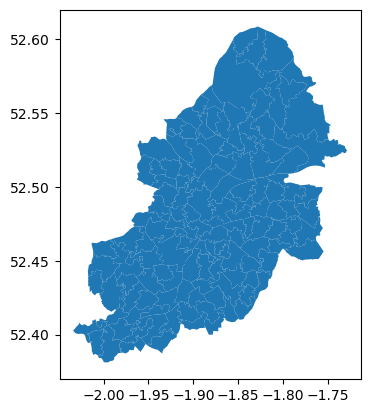

In [6]:
#Turn DataFrame into a GeoDataFrame
poly = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG: 4326")

# Visualize the map with all Middle-Sized Output Areas
poly.plot()

In [7]:
poly

,MSOA,geometry
0,b1,"POLYGON ((-1.82792 52.60789, -1.8281 52.60667,..."
1,b2,"POLYGON ((-1.81949 52.59995, -1.82132 52.59882..."
2,b3,"POLYGON ((-1.80284 52.60121, -1.80282 52.60121..."
3,b4,"POLYGON ((-1.85615 52.59822, -1.85562 52.59794..."
4,b5,"POLYGON ((-1.80364 52.57604, -1.80363 52.57603..."
...,...,...
127,b128,"POLYGON ((-1.92249 52.47853, -1.92245 52.47848..."
128,b129,"POLYGON ((-1.90874 52.4877, -1.90878 52.48751,..."
129,b130,"POLYGON ((-1.9051 52.48785, -1.90492 52.4878, ..."
130,b131,"POLYGON ((-1.87186 52.48025, -1.87185 52.48025..."


<Axes: >

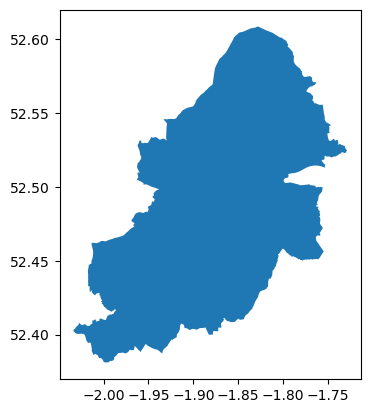

In [8]:
#Map of Birmingham as a single polygon 
p1000 = Polygon(b1000)
df1 = {"geometry": [p1000]}
poly1 = gpd.GeoDataFrame(df1, geometry='geometry'  , crs="EPSG:4326")
poly1.plot()

### Loading Population and Restaurants Data

In [10]:
#Load data of each Output Area in UK
file_pop = r"C:\Users\MyFiles\oa.xlsb"
sheet_pop =  "Sheet1"
alldf = pd.read_excel(io=file_pop, sheet_name=sheet_pop)
alldf["Coordinates"] = list(zip(alldf.X, alldf.Y))
alldf["Coordinates"] = alldf["Coordinates"].apply(Point)
allgdf = gpd.GeoDataFrame(alldf, geometry="Coordinates", crs="EPSG:4326")
allgdf.head()

#Select only those OA that fall within Birmingham polygon
all_w_birm = gpd.sjoin(poly1, allgdf)
ip_mask1 = allgdf.within(poly1.loc[0, 'geometry'])
all_data = allgdf.loc[ip_mask1]

In [11]:
#Load data of all the UK restaurants that are actively reviewed on TripAdvisor
file_rest = r"C:\Users\MyFiles\RestaurantsData2.xlsx"
sheet_rest =  "Sheet2"
restdf = pd.read_excel(io=file_rest, sheet_name=sheet_rest)
restdf["Coordinates"] = list(zip(restdf.lng, restdf.lat))
restdf["Coordinates"] = restdf["Coordinates"].apply(Point)
restgdf = gpd.GeoDataFrame(restdf, geometry="Coordinates", crs="EPSG:4326")
restgdf.head()

#Select only those restaurants that fall within Birmingham polygon
rest_w_birm = gpd.sjoin(poly1, restgdf)
ip_mask2 = restgdf.within(poly1.loc[0, 'geometry'])
rest_data = restgdf.loc[ip_mask2]

In [12]:
restgdf

,Name,FoodType,Address,British,Fastfood,Italian,French,Chinese,Japanese,MiddleEast,Pakistani,Indian,City,lat,lng,Coordinates
0,Jade Garden,"Chinese, Fast food, Asian","40 Bakers Lane, Sutton Coldfield B73 6XD, England",0,1,0,0,1,0,0,0,0,suttoncoldfield,52.563911,-1.879652,POINT (-1.87965 52.56391)
1,KuKu,"Fast food, British","22 Beeches Walk, Sutton Coldfield B73 6HN, Eng...",1,1,0,0,0,0,0,0,0,suttoncoldfield,52.554456,-1.828281,POINT (-1.82828 52.55446)
2,New Four Seasons Chinese,"Chinese, Fast food","266 Lichfield Road, Sutton Coldfield B74 2UH, ...",0,1,0,0,1,0,0,0,0,suttoncoldfield,52.585083,-1.829172,POINT (-1.82917 52.58508)
3,Pala Wood Fired Pizza,"Italian, Pizza, Fast food","446 Chester Road North | New Oscott, Sutton Co...",0,1,1,0,0,0,0,0,0,suttoncoldfield,52.548646,-1.860016,POINT (-1.86002 52.54865)
4,Domino's Pizza,"Pizza, Fast food","419 Birmingham Road, Sutton Coldfield B72 1AX,...",0,1,0,0,0,0,0,0,0,suttoncoldfield,52.535780,-1.826796,POINT (-1.8268 52.53578)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4144,Dip,"Lebanese, Mediterranean","Bullring, Birmingham B5 4BU, England",0,0,0,0,0,0,1,0,0,birmingham,52.477697,-1.894325,POINT (-1.89432 52.4777)
4145,Tom’s Kitchen Birmingham,"European, British, Vegetarian Friendly","53-57 Wharfside Street | The Mailbox, Birmingh...",1,0,0,0,0,0,0,0,0,birmingham,52.476192,-1.904584,POINT (-1.90458 52.47619)
4146,Happy Valley,"Chinese, Asian","32A Hewell Road, Birmingham B45 8NE, England",0,0,0,0,1,0,0,0,0,birmingham,52.360783,-1.990714,POINT (-1.99071 52.36078)
4147,Bella Italia Birmingham,"Italian, Vegetarian Friendly, Vegan Options","102 The Charters, New Street, Birmingham B2 4H...",0,0,1,0,0,0,0,0,0,birmingham,52.479230,-1.900258,POINT (-1.90026 52.47923)


In [13]:
#Create a GeoDataFrame containg all population data for each Middle-Size Output Area
data_merged = gpd.sjoin(allgdf , poly, how="inner", predicate='within')
poly_pop = poly.merge(data_merged, on='MSOA')
poly_pop = gpd.GeoDataFrame(poly_pop.drop(columns="Coordinates"))
poly_pop = poly_pop.dissolve(by="MSOA", aggfunc="sum")


In [14]:
#Create a GeoDataFrame containg all restaurant data for each Middle-Size Output Area
data_merged2 = gpd.sjoin(poly, restgdf ,  how="inner")
poly_rest = poly.merge(data_merged2, on='MSOA')
poly_rest = gpd.GeoDataFrame(poly_rest, geometry='geometry_x'  , crs="EPSG:4326")
poly_rest = gpd.GeoDataFrame(poly_rest.drop(columns=["geometry_y", "index_right", "Name", "FoodType", "Address", "City", "lat", "lng" ]))
poly_rest = poly_rest.dissolve(by='MSOA', aggfunc='sum')

In [15]:
#Merge restaurants and population GeoDataFrames
merged_poly = gpd.sjoin(poly_pop , poly_rest, how="inner", predicate='within')


In [16]:
#Because of the fact that some MSOAs have no restaurants in them, part of the data is lost and we recover it manually:
dfadd = {"MSOA": ["b125", "b94", "b113", "b99", "b133", "b115", "b93", "b38", "b48", "b58", "b63"], 
         "geometry": [Polygon(b125), Polygon(b94), Polygon(b113),Polygon(b99), 
                      Polygon(b133),Polygon(b115),Polygon(b93),Polygon(b38),Polygon(b48),Polygon(b58),Polygon(b63) ],
         "British": [0, 0, 0, 0, 0,0,0,0,0,0,0],
         "Fastfood": [0, 0, 0, 0, 0,0,0,0,0,0,0],"Italian":[0, 0, 0, 0, 0,0,0,0,0,0,0],
         "French":[0, 0, 0, 0, 0,0,0,0,0,0,0],"Chinese":[0, 0, 0, 0, 0,0,0,0,0,0,0],
         "Japanese":[0, 0, 0, 0, 0,0,0,0,0,0,0],
         "MiddleEast":[0, 0, 0, 0, 0,0,0,0,0,0,0], "Pakistani":[0, 0, 0, 0, 0,0,0,0,0,0,0],
         "Indian":[0, 0, 0, 0, 0,0,0,0,0,0,0],
         "Nr_UsualResidents":[8217, 7587, 5812, 6684,5812,6202,6689,5531,9352,9239,8346],
         "White":[7151, 5856, 4637,5042,4637,4725,2882,3215,1417,1192,1303 ],
         "MixedEthnic":[449, 454, 275,258,275,327,235,443,326,365,322],
         "Asian":[149,489,512,882,512,744,3120,804,6456,6447,5497 ],
         "Black":[426, 728, 254,360,254,288,259,976,960,992,897],"OtherEthnic":[42, 60,134, 142,134,58,193,93,193,243,327 ],
         "Indian_Asian":[29, 77, 193, 310,193,212,564,50,228,197,228],
         "Paki_Asian":[55, 96, 77, 108,77,369,2135,514,4927,5062,3955],
         "Bangl_Asian":[7, 14, 17, 33,17,69,126,90,531,541,887],
         "Chinese_Asian":[19, 39, 94, 190,94,10,55,25,43,36,26],"Arabian":[7, 22, 84, 60,84,37,101,56,104,131,200],
         "Q_No":[2512, 2009, 1372, 1006,1372,1668,1207,1503,2578,2132,2096],
         "Q_L1":[997, 863, 573, 442,573,696,613,646,983,900,807],"Q_L2":[989, 935,723, 583,723,787,592,585,773,713,760],
         "Q_Apprentice":[155, 152,133, 129,133,126,48,76,47,48,66],
         "Q_L3":[699, 644,481, 786,481,531,577,410,553,513,510],
         "Q_L4AndHigh":[714, 896,1325, 2364,1325,775,2144,423,698,757,755],
         "Q_Others":[289, 288,249, 245,249,192,328,243,606,642,605]}

polyadd = gpd.GeoDataFrame(dfadd, geometry='geometry'  , crs="EPSG: 4326")
merged_poly = pd.concat([merged_poly, polyadd])
merged_poly["sum"] = merged_poly["British"]+ merged_poly["Fastfood"]+merged_poly["Italian"]+merged_poly["French"]+ merged_poly["Chinese"]+merged_poly["Japanese"]+merged_poly["MiddleEast"]+merged_poly["Pakistani"]+merged_poly["Indian"]

In [17]:
#Select data of all the French restaurants
fredf = pd.read_excel(io=file_rest, sheet_name="fre")
fredf["Coordinates"] = gpd.points_from_xy(fredf.lng, fredf.lat)
fregdf = gpd.GeoDataFrame(fredf, geometry="Coordinates", crs="EPSG:4326")
fre_data = fregdf[fregdf.within(poly1.loc[0, 'geometry'])]

#Select data of all the Middle-Eastern restaurants
medf = pd.read_excel(io=file_rest, sheet_name="me")
medf["Coordinates"] = gpd.points_from_xy(medf.lng, medf.lat)
megdf = gpd.GeoDataFrame(medf, geometry="Coordinates", crs="EPSG:4326")
me_data = megdf[megdf.within(poly1.loc[0, 'geometry'])]

#Select data of all the Indian restaurants
inddf = pd.read_excel(io=file_rest, sheet_name="indnew")
inddf["Coordinates"] = gpd.points_from_xy(inddf.lng, inddf.lat)
indgdf = gpd.GeoDataFrame(inddf, geometry="Coordinates", crs="EPSG:4326")
ind_data = indgdf[indgdf.within(poly1.loc[0, 'geometry'])]

## Data Analysis

Below is the first visualization showing the distribution of restaurants by city districts. The brighter the color, the more restaurants there are in the district.

<Axes: >

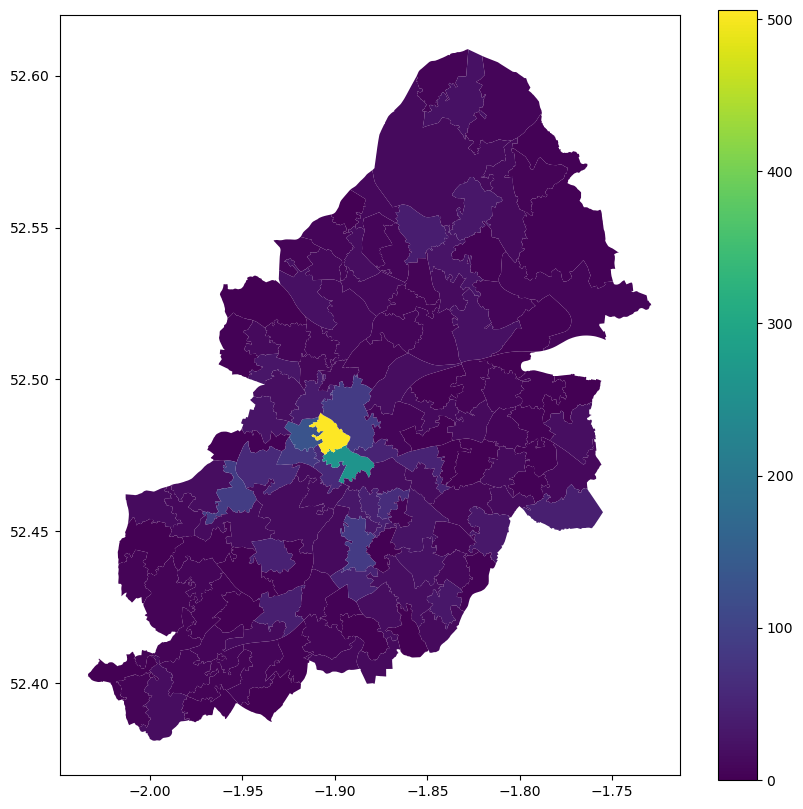

In [20]:
fig, gax = plt.subplots(figsize=(10,10))
merged_poly.plot(ax=gax, column ="sum", legend=True, markersize=0.2)

All the French (blue) and Middle-Eastern (red) restaurants plotted on the map of Birmingham.

<Axes: >

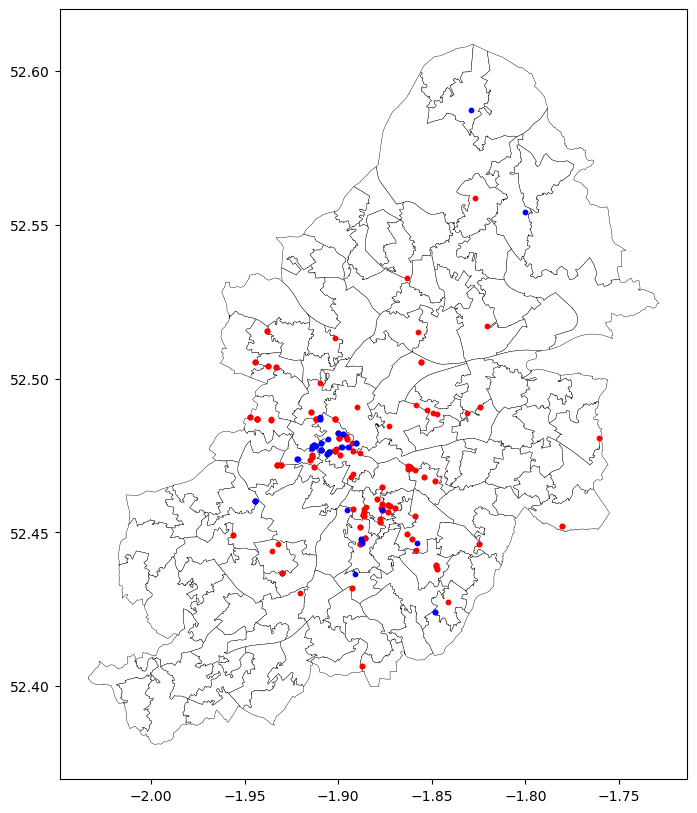

In [22]:
fig, gax = plt.subplots(figsize=(10,10))
poly.plot(ax = gax, edgecolor='black', color='white', linewidth=0.3, markersize =100000)
me_data.plot(ax=gax, alpha = 1, markersize=10, color="red") 
fre_data.plot(ax=gax, alpha = 1, markersize=10, color="blue") 


# Dispersion

## Distances to own geometric centroids

In [25]:
def havershine(coord1, coord2):
    import math
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    R = 6371  # radius of Earth in meters
    plat1 = math.radians(lat1)
    plat2 = math.radians(lat2)

    dplat = math.radians(lat2 - lat1)
    dplon = math.radians(lon2 - lon1)

    
    a = (pow(math.sin(dplat / 2), 2) + pow(math.sin(dplon / 2), 2) *math.cos(plat1) * math.cos(plat2))

    c = 2 * math.asin(math.sqrt(a))
    distance = c*R

    return distance

In [26]:
def calculate_distances(data, center_coords):
    return [havershine([row["lng"], row["lat"]], center_coords) for _, row in data.iterrows()]

# Central coordinates for different restaurant types
centers = {"M.East.": [-1.88850369, 52.46632708],
    "French": [-1.90575525, 52.47612746],
    "Indian": [-1.89521554, 52.47209579],
    "Fast f.": [-1.89458079, 52.47779201]}

# Calculate distances to own centroid
me_mecentr = calculate_distances(me_data, centers["M.East."])
fre_frecentr = calculate_distances(fre_data, centers["French"])
ind_indcentr = calculate_distances(ind_data, centers["Indian"])

# Create DataFrames for each restaurant type
data1 = pd.DataFrame(me_mecentr, columns=["Distance"]).assign(Restaurant="M.East.")
data2 = pd.DataFrame(fre_frecentr, columns=["Distance"]).assign(Restaurant="French")
data3 = pd.DataFrame(ind_indcentr, columns=["Distance"]).assign(Restaurant="Indian")

cdf = pd.concat([data1, data2, data3], ignore_index=True)

mdf = pd.melt(cdf, id_vars=['Restaurant'])

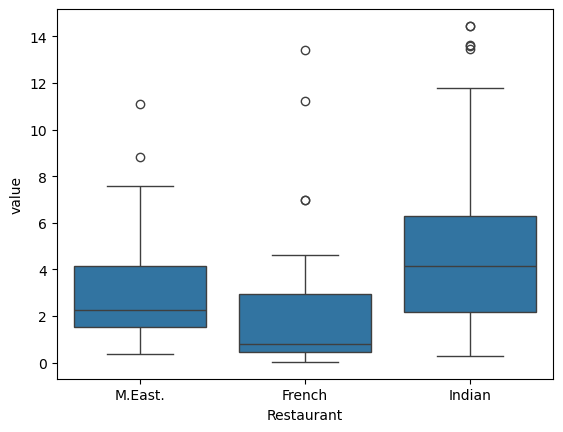

In [27]:
ax = seaborn.boxplot(x="Restaurant", y="value", data=mdf) 
plt.show()

## Standard Deviational Ellipses

With the help of Standard Deviational Ellipses it is now visible that French restaurants are much less dispersed than Indian restaurants.

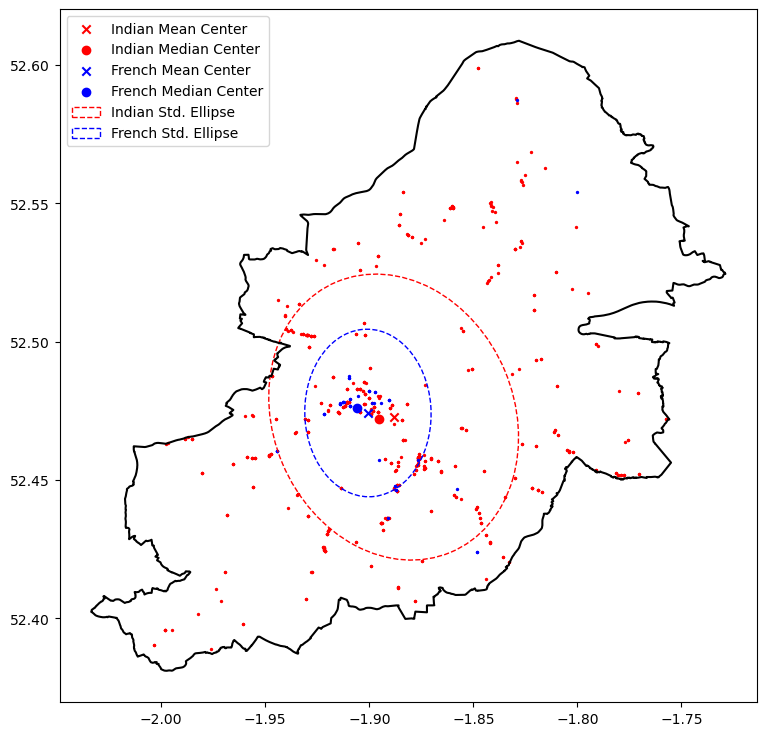

In [30]:
polygon1 = Polygon(p1000)
x,y = polygon1.exterior.xy

def calculate_centers_ellipse(data):
    mean_center = centrography.mean_center(data[["lng", "lat"]])
    med_center = centrography.euclidean_median(data[["lng", "lat"]])
    major, minor, rotation = centrography.ellipse(data[["lng", "lat"]])
    return mean_center, med_center, major, minor, rotation

mean_center1, med_center1, major1, minor1, rotation1 = calculate_centers_ellipse(ind_data)
mean_center2, med_center2, major2, minor2, rotation2 = calculate_centers_ellipse(fre_data)

f, ax = plt.subplots(1, figsize=(9, 9))

def plot_data(ax, data, mean_center, med_center, color, mean_color, label_prefix):
    ax.scatter(data["lng"], data["lat"], s=2, color=color)
    ax.scatter(*mean_center, color=mean_color, marker="x", label=f"{label_prefix} Mean Center")
    ax.scatter(*med_center, color=mean_color, marker="o", label=f"{label_prefix} Median Center")

def add_ellipse(ax, mean_center, major, minor, rotation, edge_color, label):
    ellipse = Ellipse(
        xy=mean_center,
        width=major * 2,
        height=minor * 2,
        angle=np.rad2deg(rotation),
        facecolor="none",
        edgecolor=edge_color,
        linestyle="--",
        label=label)
    ax.add_patch(ellipse)


plot_data(ax, ind_data, mean_center1, med_center1, "red", "red", "Indian")
plot_data(ax, fre_data, mean_center2, med_center2, "blue", "blue", "French")

add_ellipse(ax, mean_center1, major1, minor1, rotation1, "red", "Indian Std. Ellipse")
add_ellipse(ax, mean_center2, major2, minor2, rotation2, "blue", "French Std. Ellipse")

ax.legend()
plt.plot(x,y, color="black")


## Kernel Density Estimation

This statistic lays a grid of points over the map and places kernel functions to them that counts restaurants around them with different weights based on the distances to those restaurants. These counts are then aggregated to plot a global continuous surface with probability. Thus, at every point on the map, the probability of each restaurant being located in that place can be calculated. 

With the help of the KDE plots, it becomes clear that Middle Eastern restaurants are much less spread out compared to Indian restaurants, and their main points of concentration differ significantly

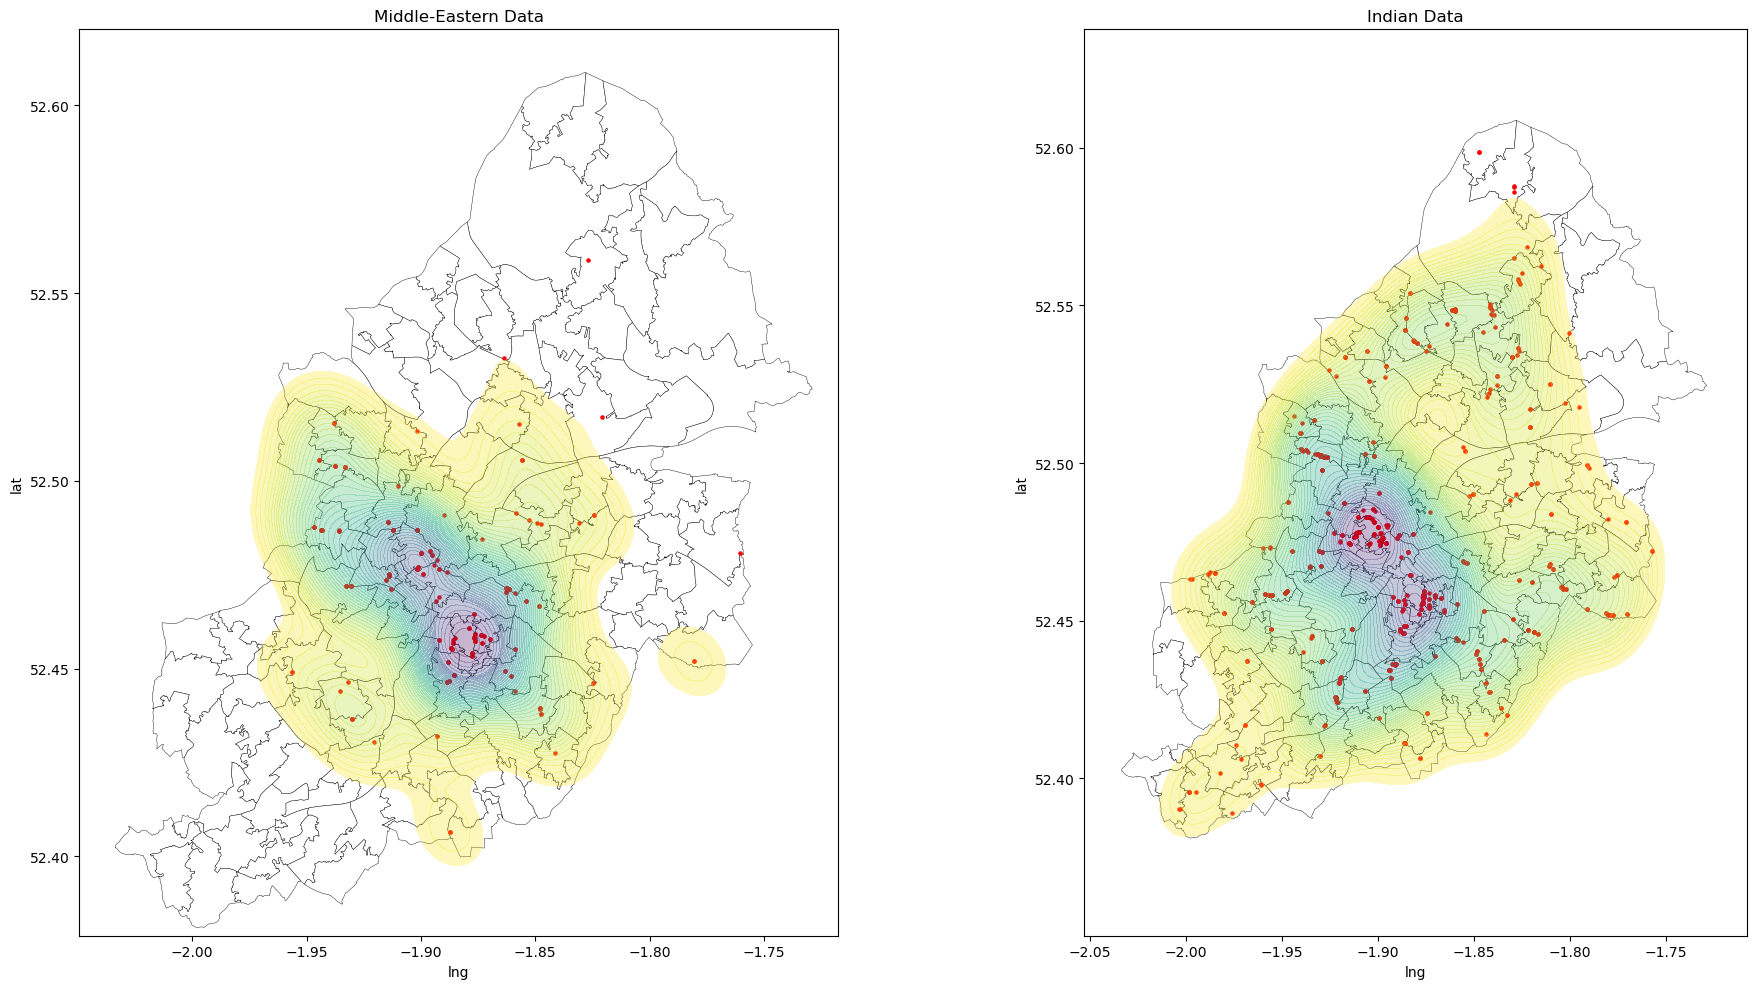

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

poly.plot(ax=ax1, edgecolor='black', color='white', linewidth=0.3)  
me_data.plot(ax=ax1, alpha=1, markersize=5, color="red")  
seaborn.kdeplot(x="lng", y="lat", data=me_data, n_levels=50, fill=True, alpha=0.3, cmap="viridis_r", ax=ax1)
ax1.set_title("Middle-Eastern Data")

poly.plot(ax=ax2, edgecolor='black', color='white', linewidth=0.3)
ind_data.plot(ax=ax2, alpha=1, markersize=5, color="red")
seaborn.kdeplot(x="lng", y="lat", data=ind_data, n_levels=50, fill=True, alpha=0.3, cmap="viridis_r", ax=ax2)
ax2.set_title("Indian Data")

plt.tight_layout()
plt.show()

## Univariate Local Moran's I

I then proceed to find the exact clusters of different types using Local Moran’s I statistic. Each MSOA has its corresponding label: HH, HL, LH, LL. Now, the significance of each Moran’s I value for each type and MSOA is assessed independently using the same technique described above. Only the statistically significant statistics are plotted on the map of Birmingham and the following discussion concerns only them. MSOAs with a number of restaurants of a certain type above sample average and neighbors having values similarly higher than average (HH) are defined as clusters. 

Using Moran’s plot, we can see that all the observations can be separated into four groups based on the values of their standardized spatial lag and standardized number of restaurants. Areas having a number of restaurants higher than the sample mean and which neighbors have values higher than the mean (HH) are defined as clusters for that particular type. Areas with a higher-than-average number of restaurants but with neighbors with values lower than average are called HL, lower than average but with neighbors with high numbers are LH, and those with less-than-average numbers inside and outside are LL. 	

Another measure of dispersion supports the previous observations: French restaurants are much more concentrated than Indian restaurants.

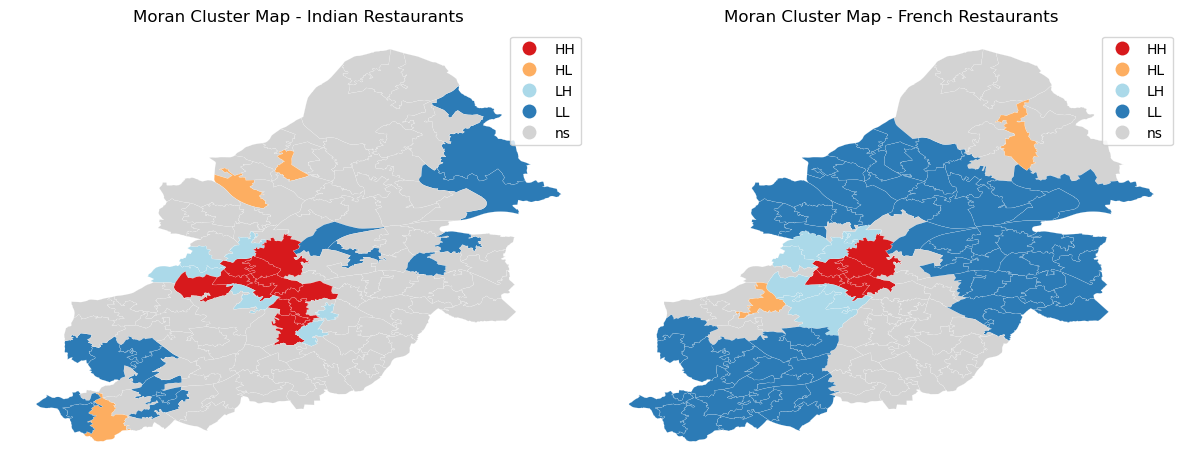

In [60]:
merged_poly = merged_poly.reset_index(drop=True)  # Reset index if necessary

w = weights.KNN.from_dataframe(merged_poly, k=8)


f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
axs = axs.flatten()

ax = axs[0]
lisa = esda.moran.Moran_Local(merged_poly["Indian"], w)
esdaplot.lisa_cluster(lisa, merged_poly, p=0.05, ax=ax)
ax.set_title("Moran Cluster Map - Indian Restaurants")

ax = axs[1]
lisa = esda.moran.Moran_Local(merged_poly["French"], w)
esdaplot.lisa_cluster(lisa, merged_poly, p=0.05, ax=ax)
ax.set_title("Moran Cluster Map - French Restaurants")


f.tight_layout()
plt.show()

## Bivariate Ripley K Function (R code)

Ripley K function can tell how likely the restaurants of some type can be found near each other, and whether there is a significant clustering or dispersion at different distances. The function is built under the assumption of isotropy – it is assumed that a one-unit distance in direction X has the same effect as one-unit distance in direction Y. Under the null hypothesis of random labelling, it is expected that the restaurants of type X are as likely to be located near other type X as they are to non-type X restaurants. This would mean that there is no clustering or repulsion within the type as if the restaurants of this type do not consider differences between type X and non-type X to be important in choosing a location. Thus, the alternative hypothesis would be that there are more / fewer observed non-British restaurants than would be expected under random labelling. 

Indian restaurants while being clustered with other types at a radius less than 250 meters, at a radius higher than 500 meters try to locate away from other Indian restaurants. 
There is a significant repulsion among Indian restaurants at 5% confidence level:

![Indian](Indian.jpg)

A significant clustering co-location pattern of french restaurants is visible from the graph below:

![French](French.jpg)

# Demographic effects

## Receiver Operating Curve

This model analyses 75% of the data for each restaurant’s MSOA’s key demographic characteristics including ethnicity and educational status of its residents. The model then employs a liblinear optimization algorithm to derive coefficients for each attribute and adjusts these estimators at each iteration moving towards the values which reduce the loss via the Logistic Loss function. 

After the training, the model performance is evaluated by testing the remaining 25% of data by using the ROC curve and the Area Under Curve (AUC). 

It is established that with a 81% chance the model can correctly distinguish between classes of Middle Eastern and non-Middle Eastern.

The model is doing worse at distinguishing Indian restaurants with probability almost indistinguishable from random guessing. 

In [74]:
data_merged2 = gpd.sjoin(restgdf , poly, how="inner", predicate='within')
merged_poly2 = gpd.sjoin(data_merged2, poly_pop , how="inner", predicate='within')

In [76]:
def train_and_evaluate(X, y, restaurant_type):
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    
    logreg = LogisticRegression(solver='liblinear')
    logreg.fit(X_train, y_train)
    
    y_pred = logreg.predict(X_test)
    y_pred_proba = logreg.predict_proba(X_test)[:, 1]
    
    # Confusion Matrix
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g', cbar=False)
    plt.title(f'Confusion Matrix for {restaurant_type} Restaurants', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = np.around(metrics.roc_auc_score(y_test, y_pred_proba), decimals=2)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc}")
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.4, label="Random Classifier")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title(f'ROC Curve for {restaurant_type} Restaurants')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc=4)
    plt.show()

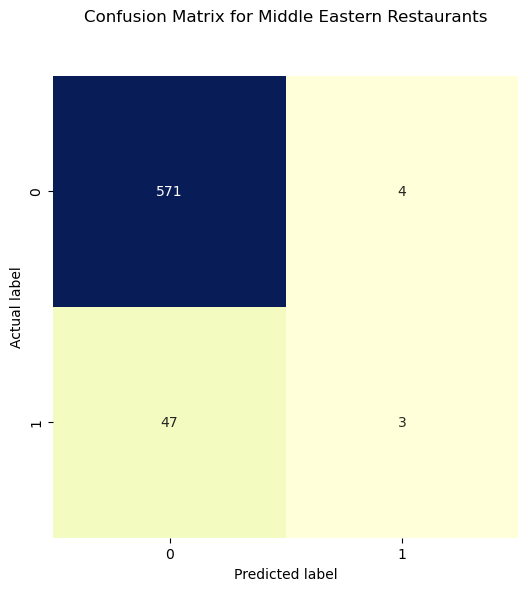

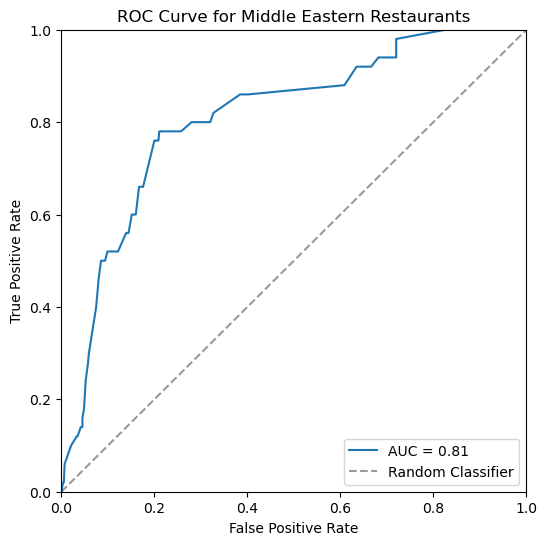

In [84]:
import seaborn as sns
feature_cols = ["White", "MixedEthnic", "Asian", "Black", "OtherEthnic", "Indian_Asian",
                "Paki_Asian", "Bangl_Asian", "Chinese_Asian", "Arabian", "Q_No","Q_L1","Q_L2","Q_Apprentice","Q_L3","Q_L4AndHigh"]

X_me = merged_poly2[feature_cols]
y_me = merged_poly2.MiddleEast

train_and_evaluate(X_me, y_me, "Middle Eastern")

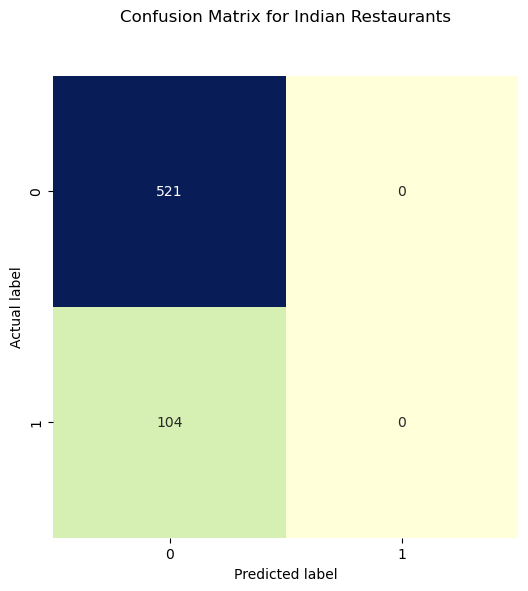

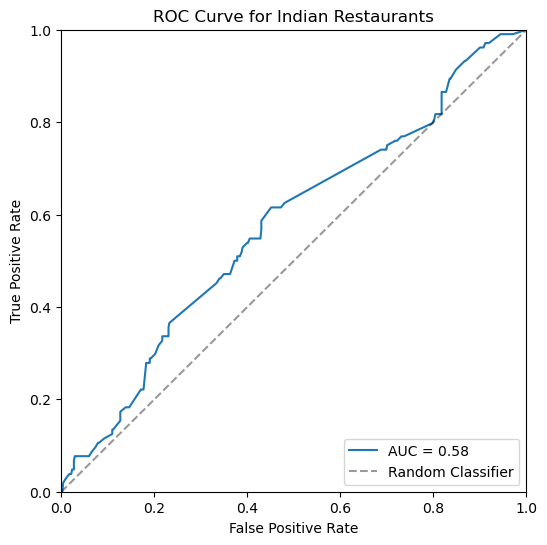

In [86]:
y_Fastfood = merged_poly2.Fastfood  

train_and_evaluate(X_me, y_Fastfood, "Indian")

## Summary

French Restaurants:

* Central Location: French restaurants are the most centrally located within the city.
* Least Dispersed: They show minimal dispersion compared to other restaurant types, indicating they tend to cluster together in close proximity.
* Proximity to Other Restaurants: French restaurants are located closer to other types of restaurants, suggesting that they benefit from being in popular, mixed dining areas.
  
Indian Restaurants:

* Away from City Center: Indian restaurants tend to establish themselves farther from the city center.
* Spatial Separation: These restaurants are more dispersed and tend to avoid close proximity to other Indian restaurants. This suggests a strategy of serving more distinct areas of the city or catering to different local markets.
  
Middle-Eastern Restaurants:

* Demographic Influence: The location of Middle-Eastern restaurants can, at least partially, be explained by demographic factors. Their primary concentration is situated to the South-East of the city center.
* Proximity to Asian Population: This area is predominantly inhabited by the Asian population, indicating a potential relationship between the geographic distribution of Middle-Eastern restaurants and the demographic makeup of the district.